In [19]:
import numpy as np
from keras import backend as K
from keras import losses
import tensorflow as tf

max_noise = 0.15
step_size = 1.0/255.0

In [2]:
x = np.array([2, -1, 3, -2, 2, 2, 1, -4, 5, 1])
w = np.array([-1, -1, 1, -1, 1, -1, 1, 1, -1, 1])

## Toy Example showing the phenomenal of fool a binary logistic  regression

'p' is the probability of be class 1.
If p > 0.5 it belongs to the class 1 otherwise not.

In [3]:
p = 1/(1+np.power(np.e, -np.dot(x, w)))
print(p)

0.04742587317756679


#### Let's try to foll the classifier

Doing the dot product again we see that suddenly the score becomes 2. This is not surprising: There are 10 dimensions and we’ve tweaked the input by 0.5 in every dimension in such a way that we gain 0.5 in each one, adding up to a total of 5 additional score, rising it from -3 to 2. Now when we look at probability of class 1 we get 1/(1+e^(-2)) = 0.88. That is, we tweaked the original x by a small amount and we improved the class 1 probability from 5% to 88%!

In [4]:
# xad = x + 0.5w gives:
xad = [1.5, -1.5, 3.5, -2.5, 2.5, 1.5, 1.5, -3.5, 4.5, 1.5]
# xad = [1.1, -1.1, 3.1, -2.1, 2.1, 1.1, 1.1, -3.1, 4.1, 1.1]

In [5]:
p = 1/(1+np.power(np.e, -np.dot(xad, w)))
print(p)

0.8807970779778823


## Reproducing the  “Deep MNIST for Experts” tutorial

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure


In [7]:
def plot_figures(X_10_samples_2, X_10_noise):
    figure(num=None, figsize=(16, 12), dpi=80, facecolor='w', edgecolor='k')
    fig = plt.figure(figsize=(30,15))

    idx_img = 0;
    for i in range(1, 30, 3):
        ax1 = fig.add_subplot(10, 3, i)
        ax1.imshow(X_10_samples_2[idx_img])
        ax2 = fig.add_subplot(10, 3, i+1)
        ax2.imshow(X_10_noise[idx_img])
        ax3 = fig.add_subplot(10, 3, i+2)
        ax3.imshow( (X_10_samples_2[idx_img] + X_10_noise[idx_img]) )

        idx_img = idx_img + 1

In [8]:
mnist = tf.keras.datasets.mnist

(x_train, y_train),(x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
arange_ = np.arange(len(y_train))

In [9]:
# with tf.device('/cpu:0'):
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(512, activation=tf.nn.relu),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
y_aux = np.zeros( (len(y_train), 10) )
y_aux[arange_, y_train] = 1
y_train = y_aux
model.fit(x_train, y_train, epochs=5)


for i in range(len(model.layers)):
    layer = model.layers[i]
    layer.trainable = False

model.compile(optimizer='adam',
          loss='categorical_crossentropy',
          metrics=['accuracy'])

model.summary()

dist_loss = K.variable(0.)
fake_class = K.variable(0)
K.set_session(tf.Session(graph=model.output.graph))
init = K.tf.global_variables_initializer()
K.get_session().run(init)

arange_ = np.arange(len(y_test))
y_aux = np.zeros( (len(y_test), 10) )
y_aux[arange_, y_test] = 1
y_test = y_aux

model.evaluate(x_test, y_test)

Epoch 1/5
60000/60000 [==============================] - 6s 93us/step - loss: 0.2198 - acc: 0.9346
Epoch 2/5
60000/60000 [==============================] - 5s 82us/step - loss: 0.0990 - acc: 0.9698
Epoch 3/5
60000/60000 [==============================] - 5s 79us/step - loss: 0.0684 - acc: 0.9786
Epoch 4/5
60000/60000 [==============================] - 5s 77us/step - loss: 0.0528 - acc: 0.9833
Epoch 5/5
60000/60000 [==============================] - 5s 79us/step - loss: 0.0418 - acc: 0.9862
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               401920    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
___________________________________________

[0.06789418366739992, 0.98]

#### Selecting samples from the 2

In [20]:
y_train_idx = np.argmax(y_train, axis=1)
print(y_train_idx)
X_samples_2 = np.copy(x_train[y_train_idx==2])
X_samples_2_orig = np.copy(x_train[y_train_idx==2])
X_noises = np.zeros((X_samples_2.shape[0], 28, 28))

Y_samples_2 = y_train[np.argmax(y_train, axis=1)==2]
Y_fakes = np.copy(Y_samples_2)
Y_fakes[:, 2] = 0
Y_fakes[:, 6] = 1

print("X_samples_2.shape "+ str(X_samples_2.shape))
print("Y_samples_2.shape "+str(Y_samples_2.shape))
print("X_noises.shape "+str(X_noises.shape))
print("Y_fakes.shape "+str(Y_fakes.shape))

[5 0 4 ... 5 6 8]
X_samples_2.shape (5958, 28, 28)
Y_samples_2.shape (5958, 10)
X_noises.shape (5958, 28, 28)
Y_fakes.shape (5958, 10)


#### In the fisrt way to try fool the Neural Network I will follow this steps.
* Get image samples of 2 and target it as 6
* Apply the feedforward in CNN
* Get the gradient and apply it on image
* Get the difference of new image and original image as noise

### Applying Ian Goodfellow method.  This method utiliza just the sign of gradient. And global pertubations.

In [21]:
# Getting gradient
input_img = model.input
fake_class = K.zeros(shape=(1, 10))

layer = model.layers[-1]
print(layer.output)

# distance Loss
# np.random.seed(1)
# for x in np.random.choice(model.layers[:-1], size = len(model.layers) - 1):
#     x_var = x.output
#     dist_loss = dist_loss + np.random.uniform(0,2) * K.sum(K.square(x_var)) / K.prod(K.cast(K.shape(x_var), 'float32'))
    

# adversarial loss
adversarial_loss = losses.categorical_crossentropy(fake_class, layer.output)# - dist_loss

grads = K.gradients(adversarial_loss, model.input)[0]
print(grads)
grads = grads / K.maximum(K.abs(K.max(grads)), K.abs(K.min(grads)))

print(input_img.shape)
print(fake_class.shape)
grads_func = K.function(inputs=[input_img, fake_class], outputs=[grads])

Tensor("dense_1/Softmax:0", shape=(?, 10), dtype=float32)
Tensor("gradients_2/flatten/Reshape_grad/Reshape:0", shape=(?, 28, 28), dtype=float32)
(?, 28, 28)
(1, 10)


In [23]:
# fig = plt.figure(figsize=(30,15))
unique_noise = X_noises[0]
total_found = 0
idx_found =[]

for it in range(50):
    print("Iteration: "+ str(it))
    for sample_idx in range(X_samples_2.shape[0]):
        sample = np.reshape(X_samples_2_orig[sample_idx], (1,28,28))
        predicted = model.predict(np.array(sample))
        predicted_idx = np.argmax(predicted)

        if predicted_idx != 2 or sample_idx in idx_found:
            continue
        if total_found >= 10:
            break

        for i in range(50):
            fuzzy_img = (X_samples_2[sample_idx] + unique_noise)
            fuzzy_img = np.clip(fuzzy_img, 0, 1)
            fuzzy_img = np.reshape(fuzzy_img, (1, 28, 28))

            predicted = model.predict(fuzzy_img)[0]
            predicted_idx = np.argmax(predicted)
            if predicted_idx == 6:
                idx_found.append(sample_idx)
                X_noises[total_found] = np.copy(unique_noise)
                total_found = total_found + 1
                if total_found < 10:
                    unique_noise = X_noises[total_found]
                    
                print("img "+ str(sample_idx) + "  pred: " + str(predicted_idx) + "  Confiance: " + str(predicted[6]) )
                break

            #Update noise
            Y_fakes_hot_ones = np.zeros((1,10), dtype='int8')
            Y_fakes_hot_ones[0, 6] = 1
            grads = grads_func([fuzzy_img, Y_fakes_hot_ones])
            grads = np.array(grads[0][0])
            unique_noise = np.clip((unique_noise - (np.sign(grads)*step_size)), -max_noise, max_noise)
        
#         break
#     break
# print(sample, ' - predicted - ', predicted_idx, '  --  ', predicted[0, 2], '  --  ', predicted[0, 6], '  --  ', predicted[0, predicted_idx])
# print('-----------------------------------------------------------------------------------------------\n')

Iteration: 0
img 1560  pred: 6  Confiance: 0.7086325
img 2065  pred: 6  Confiance: 0.5061566
img 2730  pred: 6  Confiance: 0.46758485
img 3900  pred: 6  Confiance: 0.8139237
img 3909  pred: 6  Confiance: 0.73357105
img 4125  pred: 6  Confiance: 0.5027775
img 4652  pred: 6  Confiance: 0.579142
img 5595  pred: 6  Confiance: 0.53026825
Iteration: 1
Iteration: 2
img 1654  pred: 6  Confiance: 0.45345715
img 2741  pred: 6  Confiance: 0.4065541
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18
Iteration: 19
Iteration: 20
Iteration: 21
Iteration: 22
Iteration: 23
Iteration: 24
Iteration: 25
Iteration: 26
Iteration: 27
Iteration: 28
Iteration: 29
Iteration: 30
Iteration: 31
Iteration: 32
Iteration: 33
Iteration: 34
Iteration: 35
Iteration: 36
Iteration: 37
Iteration: 38
Iteration: 39
Iteration: 40
Iteration: 41
Iteration: 42
Itera

Images used: [1560, 2065, 2730, 3900, 3909, 4125, 4652, 5595, 1654, 2741]
(10, 28, 28)
(10, 28, 28)

Predicting original images
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2]

Predicting images with pertubation
[6, 6, 6, 6, 6, 6, 6, 6, 6, 6]


<Figure size 1280x960 with 0 Axes>

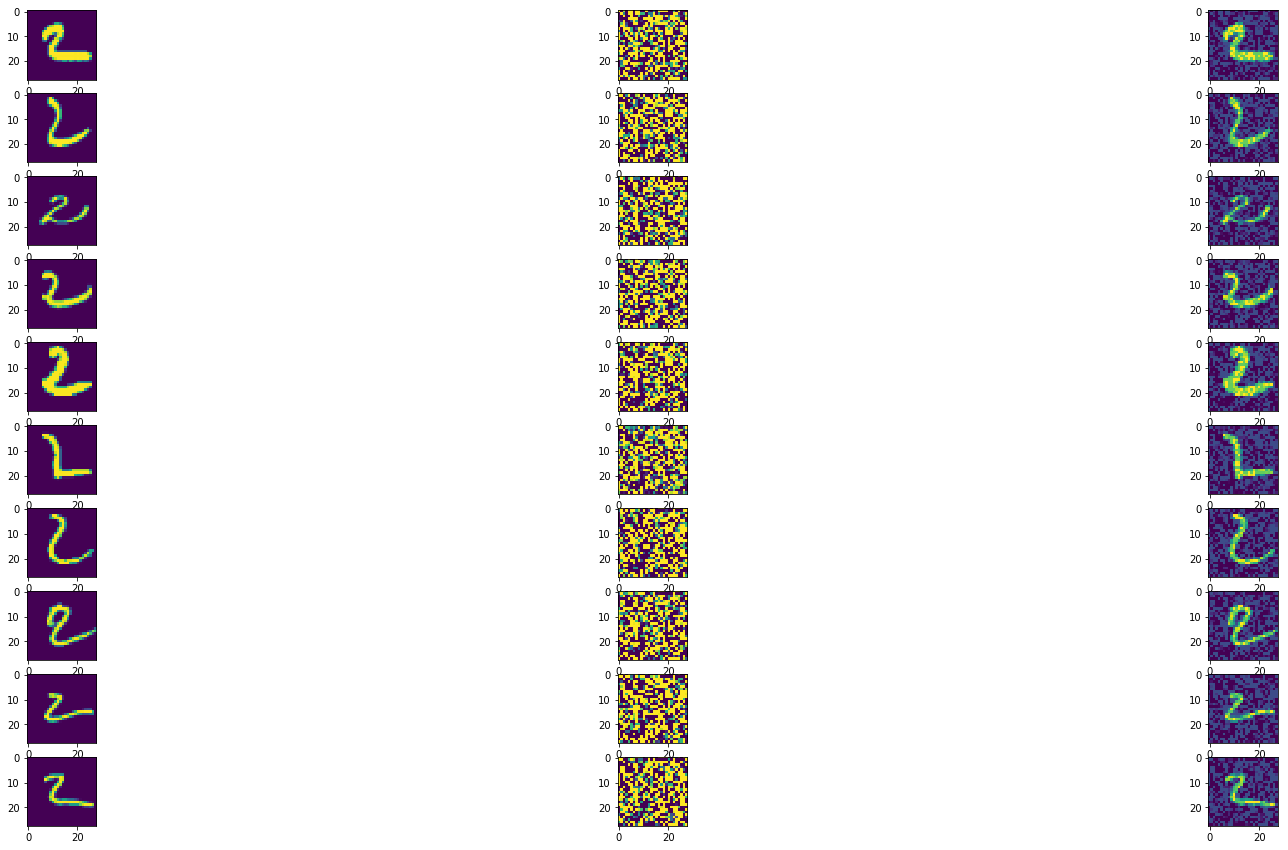

In [24]:
print("Images used: " + str(idx_found))
imgs_used = X_samples_2[idx_found]
noises_used = X_noises[:imgs_used.shape[0]]
print(imgs_used.shape)
print(noises_used.shape)

print("\nPredicting original images")
pred = [np.argmax(model.predict((imgs_used))[i]) for i in range(imgs_used.shape[0])]
print(pred)

print("\nPredicting images with pertubation")
pred = [np.argmax(model.predict(np.clip((imgs_used + noises_used), 0, 1))[i]) for i in range(imgs_used.shape[0])]
print(pred)


plot_figures(imgs_used, noises_used)

### Trying AG approach

In [99]:
def create_population(n):
    pop = []
    for i in range(n):
        individual = np.zeros(28*28) # np.array([np.random.normal()/5 for _ in range(28*28)])
        individual = np.reshape(individual, (28,28))
        for i in range(28):
            for j in range(28):
#                 if (i<4 or i>23) or (j<4 or j>23):
                individual[i,j] = ((np.random.randint(256)/255.0)/10.0)
                if np.random.rand()>0.5:
                    individual[i,j] = -individual[i,j]
        individual = np.reshape(individual, (28*28))
        individual = np.clip(individual, -max_noise, max_noise)
        pop.append(individual)
        
    return np.array(pop)

In [102]:
def evaluate_population(pop):
    ranking = []
    pred = model.predict(X_samples_2_orig)
    pred_idx = [ np.argmax(pred[i]) for i in range(X_samples_2_orig.shape[0]) ]
    pred_idx = np.array(pred_idx)
    
    X_samples_2_eval = np.copy(X_samples_2_orig[pred_idx==2])
    
    for individual in pop:
        X_noise = np.reshape(individual, (1, 28, 28))
        fuzzy_imgs = (X_samples_2_eval + X_noise)
        fuzzy_imgs = np.clip(fuzzy_imgs, 0, 1)

        pred = model.predict(fuzzy_imgs)
        pred_idx = [ np.argmax(pred[i]) for i in range(fuzzy_imgs.shape[0]) ]
        pred_idx = np.array(pred_idx)
        value = np.sum(pred, axis=0)[6]
        value = value + (np.sum(pred_idx==6)*100)
        ranking.append(value)
        
    return ranking

In [103]:
def mutation(individual, probability):
    individual = np.reshape(individual, (28,28))
    for i in range(28):
        for j in range(28):
#             if (i<4 or i>23) or (j<4 or j>23):
            if np.random.rand() < probability:
                individual[i, j] = individual[i, j] + ((np.random.randint(256)/255.0)/10.0) # np.random.normal()/10

    individual = np.reshape(individual, (28*28))
    individual = np.clip(individual, -max_noise, max_noise)
    return np.array(individual)

def crossover(ind1 , ind2):
    position = np.random.randint(len(ind1))
    new_individual1 = np.concatenate((ind1[:position], ind2[position:]))
    new_individual2 = np.concatenate((ind2[:position], ind1[position:]))
    return np.array(new_individual1), np.array(new_individual2)

In [105]:
num_epoch = 10000
pop_size = 1000
best_inds = 100

pop = create_population(pop_size)
best_val = []
best_number_of_six = []

pred = model.predict(X_samples_2_orig)
pred_idx = [ np.argmax(pred[i]) for i in range(X_samples_2_orig.shape[0]) ]
pred_idx = np.array(pred_idx)

X_samples_2_GA = np.copy(X_samples_2_orig[pred_idx==2])

for epoch in range(num_epoch):
    ranking = np.array(evaluate_population(pop))
    ordered_idx = ranking.argsort()
    pop_ordered = pop[ordered_idx]
    top_inds = np.array(pop_ordered[-best_inds:])
    other_ind = np.array(pop[ordered_idx][:-best_inds])
    best_val.append(ranking[ordered_idx][-1])
    
    new_pop = []
    for _ in range(int(pop_size/4)):
        ind1 = top_inds[np.random.randint(len(top_inds))]
        ind2 = top_inds[np.random.randint(len(top_inds))]
        new_ind1, new_ind2 = crossover(ind1, ind2)
        new_pop.append(new_ind1)
        new_pop.append(new_ind2)
    
    pop_with_mutation = []
    for i in range(len(new_pop)):
        pop_with_mutation.append(mutation(new_pop[i], probability=0.05))

    pop_with_mutation = np.concatenate((create_population(pop_size - best_inds - len(pop_with_mutation)), pop_with_mutation))
    pop = np.concatenate((top_inds, pop_with_mutation))
    if (epoch % 50)==0:
        for top in top_inds:
            top_noise = np.reshape(top, (1, 28, 28))
            fuzzy_elements = (X_samples_2_GA + top_noise)
            fuzzy_elements = np.clip(fuzzy_elements, 0, 1)

            pred = model.predict(fuzzy_elements)
            pred = np.array([np.argmax(pred[i]) for i in range(10)])
            value = np.sum(pred==6)
            best_number_of_six.append(value)
        print(epoch, ' - best value: ', best_val[len(best_val) - 1])
        print(best_number_of_six)
        print()
        
    if np.max(np.array(best_number_of_six)) >= 10:
        break
    

ranking = np.array(evaluate_population(pop))
ordered_idx = ranking.argsort()
top20 = np.array(pop[ordered_idx][-5:])

print(top20)
print(ranking)
print(ranking[ordered_idx][-5])
print(best_val)

0  - best value:  310.88908863067627
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

50  - best value:  58193.42236328125
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

100  - best value:  76

KeyboardInterrupt: 

In [ ]:
pred = model.predict(X_samples_2_orig)
pred_idx = [ np.argmax(pred[i]) for i in range(X_samples_2_orig.shape[0]) ]
pred_idx = np.array(pred_idx)

X_samples_2_eval = np.copy(X_samples_2_orig[pred_idx==2])
    
individual = p[0]

X_noise = np.reshape(individual, (1, 28, 28))
fuzzy_imgs = (X_samples_2_eval + X_noise)
fuzzy_imgs = np.clip(fuzzy_imgs, 0, 1)

pred = model.predict(fuzzy_imgs)
pred_idx = [ np.argmax(pred[i]) for i in range(fuzzy_imgs.shape[0]) ]
pred_idx = np.array(pred_idx)

imgs_used = X_samples_2_eval[np.where(pred_idx==6)[0]]
imgs_fuzzy = imgs_used + X_noise
imgs_fuzzy = np.clip(imgs_fuzzy, 0, 1)

print("Images used: " + str(np.where(pred_idx==6)[0]))

print("\nPredicting original images")
pred = [np.argmax(model.predict((imgs_used))[i]) for i in range(imgs_used.shape[0])]
print(pred)

print("\nPredicting images with pertubation")
pred = [np.argmax(model.predict(imgs_fuzzy)[i]) for i in range(imgs_used.shape[0])]
print(pred)

plot_figures(imgs_used, noises_used)

## GAN GENARATOR

In [ ]:
model_gan = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(8, activation=tf.nn.sigmoid),
  tf.keras.layers.Dense(16, activation=tf.nn.relu),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(64, activation=tf.nn.relu),
  tf.keras.layers.Dense(128, activation=tf.nn.sigmoid),
  tf.keras.layers.Dense(256, activation=tf.nn.relu),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(512, activation=tf.nn.relu),
  tf.keras.layers.Dense(512, activation=tf.nn.sigmoid),
  tf.keras.layers.Dense(512, activation=tf.nn.sigmoid),
  tf.keras.layers.Dense(512, activation=tf.nn.relu),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(28*28, activation=tf.nn.sigmoid),
  tf.keras.layers.Dense(28*28, activation=tf.keras.activations.relu(alpha=0.33, max_value=0.25, threshold=-0.25)),
])

compose_model = tf.keras.models.Sequential([
    model_gan,
    model
])

model_gan.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

compose_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

compose_model.fit(X_samples_2, Y_fakes, epochs=80)

In [ ]:
print( np.argmax(compose_model.predict(X_samples_2)[0]) )
print( np.argmax(model.predict(X_samples_2)[0]) )

noises = np.reshape(model_gan.predict(X_samples_2), (X_samples_2.shape[0], 28, 28)) - X_samples_2
print(noises.shape)

X_10_noise = noises

# ---------- Elimining pertubation on center image ------------------
# for e in range(X_samples_2.shape[0]):
#     for i in range(28):
#         for j in range(28):
#             if i >2 and i<25 and j>2 and j<23:
#                 X_10_noise[e, i, j] = 0
#                 continue
# ---------- Elimining pertubation on center image ------------------


new_elements = (X_10_samples_2 + X_10_noise)

pred = model.predict(new_elements)
pred = np.array([np.argmax(pred[i]) for i in range(10)])


print(pred)
plot_figures(X_10_samples_2, X_10_noise)

### Trying an Reinforcement Learning

In [ ]:
prop_action_states = dict()

def get_state(noise):
    noise = np.copy(noise)
    for i in range(len(noise)):
        if noise[i] > .9:
            noise[i] = .9
        elif noise[i] > .8:
            noise[i] = .8
        elif noise[i] > .7:
            noise[i] = .7
        elif noise[i] > .6:
            noise[i] = .6
        elif noise[i] > .5:
            noise[i] = .5
        elif noise[i] > .4:
            noise[i] = .4
        elif noise[i] > .3:
            noise[i] = .3
        elif noise[i] > .2:
            noise[i] = .2
        elif noise[i] > .1:
            noise[i] = .1
        else:
            noise[i] = .0
    
    return noise

def Q_function(state, noise, action):
    X_10_noise = np.reshape(individual, (28, 28))
    pred = model.predict((X_10_samples_2 + X_10_noise))
    value = np.sum(pred, axis=0)[6]
    
    return value


In [ ]:
def get_best_action(state):
    state_name = ''
    for i in range(28*28):
        state_name = state_name + str(state[i])
    
    if state_name not in prop_action_states:
        prop_action = np.zeros(28*28)
        prop_action = np.reshape(prop_action, (28,28))
        prop_action[:4, :] = .5
        prop_action[:-4, :] = .5
        prop_action[:, :-4] = .5
        prop_action[:, :4] = .5
        prop_action = np.reshape(prop_action, (28*28))
        prop_action_states[state_name] = prop_action
    
    prop_action = prop_action_states.get(state_name)
    best_indices = np.where(prop_action == prop_action.max())[0]
#     print(prop_action.max(), "best_indices ", len(best_indices[0]))
    return best_indices[np.random.randint(len(best_indices))]

def update_prop_action_states(state, action, value):
    state_name = ''
    for i in range(28*28):
        state_name = state_name + str(state[i])
    
    if state_name not in prop_action_states:
        prop_action = np.zeros(28*28)
        prop_action = np.reshape(prop_action, (28,28))
        prop_action[:4, :] = .5
        prop_action[:-4, :] = .5
        prop_action[:, :-4] = .5
        prop_action[:, :4] = .5
        prop_action = np.reshape(prop_action, (28*28))
        prop_action_states[state_name] = prop_action
    
    prop_action = prop_action_states.get(state_name)
    prop_action[action] = prop_action[action] + value
    prop_action_states[state_name] = prop_action

In [ ]:
max_actions = (28*28*10)
num_train_times = 100
best_val = 0

for num_train_time in range(num_train_times):
    initial_noise = np.zeros(28*28)
    initial_state = get_state(initial_noise)
    state = np.array(initial_state)
    noise = np.array(initial_noise)
    
    print('num_train ', num_train_time, ' -- best val until now: ', best_val)
    for action_time in range(max_actions):
        top_noise = np.reshape(noise, (28, 28))
        new_element = (X_10_samples_2 + top_noise)
        pred = model.predict(new_element)
        actual_val = np.sum(pred[:, 6])
        
        # Select an action (Explore or Exploit)
        action = -1
        if np.random.rand() < .2: # Explore
            rand_i = np.random.randint(8)
            rand_i = rand_i if rand_i < 5 else (19 + rand_i)
            rand_j = np.random.randint(8)
            rand_j = rand_j if rand_j < 5 else (19 + rand_j)
            action = (rand_i*28) + rand_j
        else: # Exploite
            action = get_best_action(state)

        # Apply Action
        noise_added = np.random.randint(256)/255.0
        if np.random.rand() > .5:
            noise_added = -noise_added
        noise[action] = noise[action] + noise_added
        noise[action] = np.minimum((noise[action]), 1)
        noise[action] = np.maximum((noise[action]), 0)
        
        # Getting Reward
        top_noise = np.reshape(noise, (28, 28))
        new_element = (X_10_samples_2 + top_noise)
        pred = model.predict(new_element)
        new_value = np.sum(pred[:, 6])
        
        if best_val < new_value:
            best_val = new_value

        if new_value > 9.5:
            break
        
        if action_time%1000 == 0:
            print('\nnoise add: ', noise_added, ' in position ', action, '(', int(action/28), ', ', (action%28), ')')
            print('\naction_time ', action_time, ' -- best val: ', best_val,' -- actual_val: ', actual_val, '  -- new_val', new_value,'  ** diff values: ', (new_value - actual_val))
#             print(noise)
            
        # Update Q_Function
        update_prop_action_states(state, action, (0.02 if (new_value - actual_val) > 0 else -.02))
        
        # Generating new state
        state = get_state(noise)

In [ ]:
X_10_noise = np.zeros((10, 28, 28))
for i in range(10):
    X_10_noise[i] = np.reshape((top_noise), (1, 28,28))
    
new_element = (X_10_samples_2 + X_10_noise)
pred = model.predict(new_element)
pred = np.array([np.argmax(pred[i]) for i in range(10)])


print(pred)
plot_figures(X_10_samples_2, X_10_noise)

In [ ]:
.0816-(.0816*.15)
.064*.93
1461/365